In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import recall_score,precision_score,confusion_matrix
from collections import Counter

In [74]:
Tel=pd.read_csv('C:\\Users\\gramakot\\OneDrive - UHG\\Upgrad\\TelecomeChurnGroupCaseStudy\\train.csv')
Tel['churn_probability'].value_counts()
Drop=['id','circle_id','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
Tel.drop(Drop,axis=1,inplace=True)
Null_Info=pd.DataFrame(Tel.isnull().sum()).reset_index()
Null_Info.columns=['Columns','Null_Count']
Null_Info[Null_Info['Null_Count']!=0]['Null_Count'].value_counts()
Drop_Col_Na=list(Null_Info[Null_Info['Null_Count'].isin([52431,52134,51582])]['Columns'])

**Imputing NA with zeros for below columns**

In [75]:
rech_col_imp=['total_rech_data_6','total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']
Tel[rech_col_imp]=Tel[rech_col_imp].fillna(value=0)

In [76]:
Tel['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

**Created new columns for amount fields, If a user is churning he will not show interest to use services in the last month in our case it is August**

In [77]:
Tel['Total_data_rech_amt_6']=Tel['total_rech_data_6'].fillna(0) * Tel['av_rech_amt_data_6'].fillna(0)
Tel['Total_data_rech_amt_7']=Tel['total_rech_data_7'].fillna(0) * Tel['av_rech_amt_data_7'].fillna(0)
Tel['Total_data_rech_amt_8']=Tel['total_rech_data_8'].fillna(0) * Tel['av_rech_amt_data_8'].fillna(0)
Tel['Total_rech_amt_both_6']=Tel['Total_data_rech_amt_6']+Tel['total_rech_amt_6'].fillna(value=0)
Tel['Total_rech_amt_both_7']=Tel['Total_data_rech_amt_7']+Tel['total_rech_amt_7'].fillna(value=0)
Tel['Total_rech_amt_both_8']=Tel['Total_data_rech_amt_8']+Tel['total_rech_amt_8'].fillna(value=0)
Tel['High_value_det']=(Tel['Total_rech_amt_both_6']+Tel['Total_rech_amt_both_7'])/2

In [78]:
Tel['High_value_det'].quantile(0.7)

477.5

In [79]:
Tel_HVC=Tel[Tel['High_value_det']>=477.5]
Tel_HVC['churn_probability'].value_counts()

0    19274
1     1739
Name: churn_probability, dtype: int64

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_8'>

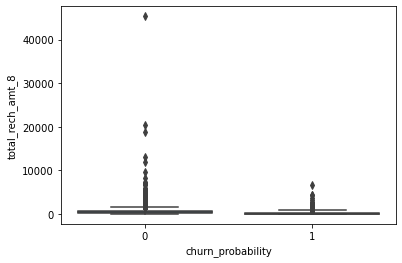

In [80]:
sns.boxplot(x='churn_probability',y='total_rech_amt_8',data=Tel_HVC)

**All the below columns can be combined to form other columns so these can be dropped**

In [81]:
Drop_Col_Na1=['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
             ,'loc_ic_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2o_mou_6','spl_ic_mou_6','isd_ic_mou_6','ic_others_6'
             ,'loc_ic_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7','std_ic_t2o_mou_7','spl_ic_mou_7','isd_ic_mou_7','ic_others_7'
             ,'loc_ic_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8','std_ic_t2o_mou_8','spl_ic_mou_8','isd_ic_mou_8','ic_others_8'
             ,'std_og_mou_6','std_og_t2c_mou_6','std_og_t2f_mou_6','std_og_t2m_mou_6','std_og_t2t_mou_6','loc_og_mou_6','loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','isd_og_mou_6','spl_og_mou_6','og_others_6'
             ,'std_og_mou_7','std_og_t2c_mou_7','std_og_t2f_mou_7','std_og_t2m_mou_7','std_og_t2t_mou_7','loc_og_mou_7','loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','isd_og_mou_7','spl_og_mou_7','og_others_7'
             ,'std_og_mou_8','std_og_t2c_mou_8','std_og_t2f_mou_8','std_og_t2m_mou_8','std_og_t2t_mou_8','loc_og_mou_8','loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','isd_og_mou_8','spl_og_mou_8','og_others_8']

Tel_HVC.drop(Drop_Col_Na1,inplace=True,axis=1)

In [82]:
Null_Info=pd.DataFrame(Tel_HVC.isnull().sum()).reset_index()
Null_Info.columns=['Columns','Null_Count']
Null_Info[Null_Info['Null_Count']!=0]['Null_Count'].value_counts()

397     5
393     5
822     5
9327    4
9094    4
9833    4
167     3
Name: Null_Count, dtype: int64

In [83]:
Drop_Col_Na=list(Null_Info[Null_Info['Null_Count'].isin([9327,9094,9833])]['Columns'])
Tel_HVC.drop(Drop_Col_Na,inplace=True,axis=1)

(-1000.0, 5000.0)

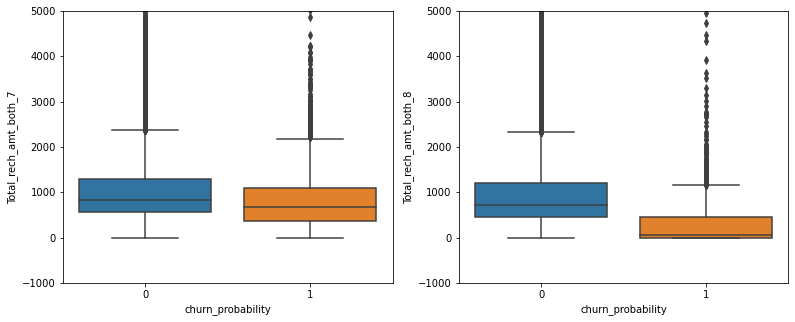

In [84]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=Tel_HVC,y='Total_rech_amt_both_7',x='churn_probability')
plt.ylim(-1000,5000)
plt.subplot(1,2,2)
sns.boxplot(data=Tel_HVC,y='Total_rech_amt_both_8',x='churn_probability')
plt.ylim(-1000,5000)

**As expected in the month of August there is less usage**

(-1000.0, 2000.0)

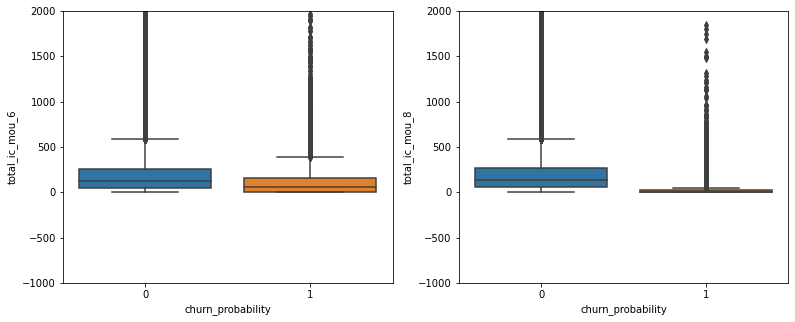

In [85]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=Tel,y='total_ic_mou_6',x='churn_probability')
plt.ylim(-1000,2000)
plt.subplot(1,2,2)
sns.boxplot(data=Tel,y='total_ic_mou_8',x='churn_probability')
plt.ylim(-1000,2000)

(-1000.0, 2000.0)

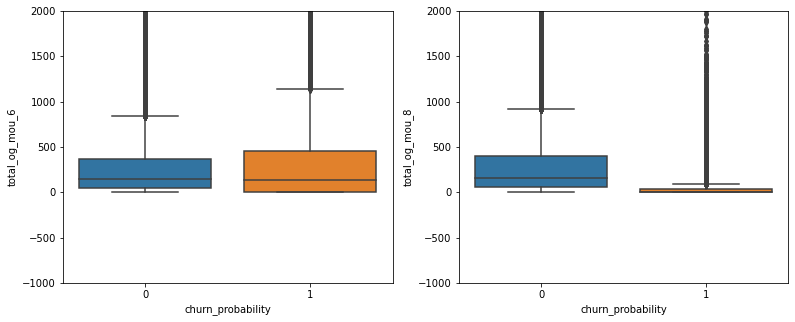

In [86]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=Tel,y='total_og_mou_6',x='churn_probability')
plt.ylim(-1000,2000)
plt.subplot(1,2,2)
sns.boxplot(data=Tel,y='total_og_mou_8',x='churn_probability')
plt.ylim(-1000,2000)

(-1000.0, 2000.0)

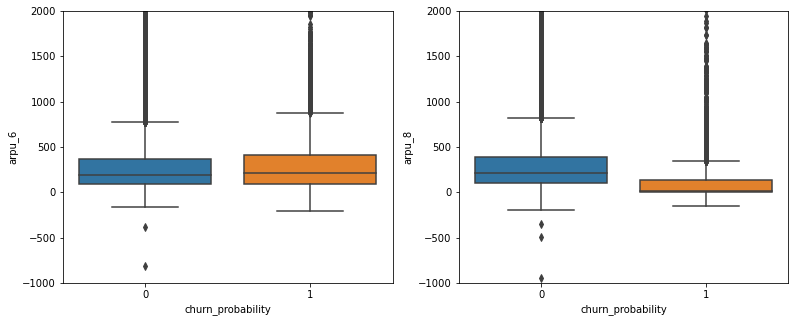

In [87]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=Tel,y='arpu_6',x='churn_probability')
plt.ylim(-1000,2000)
plt.subplot(1,2,2)
sns.boxplot(data=Tel,y='arpu_8',x='churn_probability')
plt.ylim(-1000,2000)

(0.0, 1000.0)

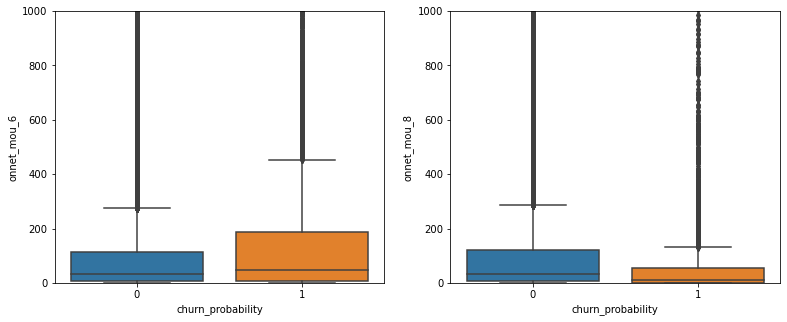

In [132]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=Tel,y='onnet_mou_6',x='churn_probability')
plt.ylim(0,1000)
plt.subplot(1,2,2)
sns.boxplot(data=Tel,y='onnet_mou_8',x='churn_probability')
plt.ylim(0,1000)

In [128]:
#sns.displot()
#sns.displot(data=Tel,y='vol_2g_mb_6',x='churn_probability')
#sns.displot(Tel_HVC['vol_2g_mb_6'])
Tel_HVC['sachet_2g_8'].describe()

count    21013.000000
mean         1.054109
std          2.540754
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         44.000000
Name: sachet_2g_8, dtype: float64

In [90]:
Tel_HVC.columns

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'vol_2g_mb_6', 'vol_2g

**Imputing NAN with median values**

In [91]:
dict_na=dict(Tel_HVC.median())
Tel_HVC=Tel_HVC.fillna(value=dict_na)

In [92]:
Null_Info=pd.DataFrame(Tel_HVC.isnull().sum()).reset_index()
Null_Info.columns=['Columns','Null_Count']
Null_Info[Null_Info['Null_Count']!=0]['Null_Count'].value_counts()

Series([], Name: Null_Count, dtype: int64)

In [93]:
X=Tel_HVC.drop('churn_probability',axis=1)
y=Tel_HVC['churn_probability']
Counter(y)

Counter({0: 19274, 1: 1739})

**Since our data is imbalanced using SMOTE to generate synthetic data**

In [94]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
Counter(y)

Counter({0: 19274, 1: 19274})

In [95]:
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8,random_state=18)
sc=StandardScaler()
X_train_sc=sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

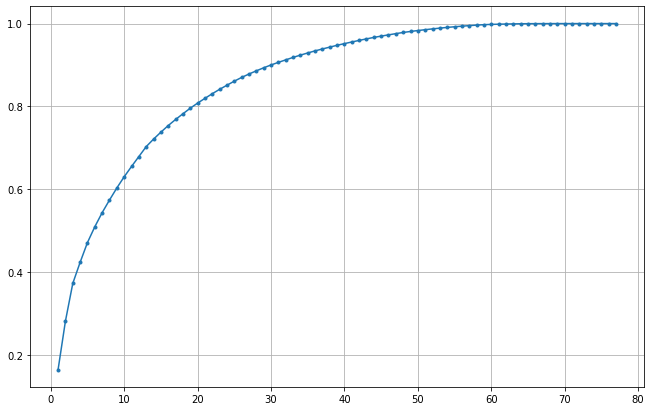

In [96]:
pca=PCA(random_state=18)
pca.fit(X_train_sc)
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(11,7))
plt.plot(range(1,len(var_cumu)+1), var_cumu,marker='.')
plt.grid()

**Using PCA to reduce number of dimensions**

In [97]:
pca=PCA(n_components=50,random_state=18)
X_train_PCA=pca.fit_transform(X_train_sc)
X_test_PCA=pca.transform(X_test_sc)


**Applying XGBoost Technique**

In [29]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':[1,10,20,30,50],
 'n_estimators':[100,200,250,300],
 'alpha':[0,0.2,0.5,0.8,1],
 'gamma':[0,0.2,0.5,0.8,1]
}

In [98]:
gsearch1 = RandomizedSearchCV(estimator = XGBClassifier( learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_distributions = param_test1, scoring='recall',n_jobs=-1, cv=5,verbose=True)
gsearch1.fit(X_train_PCA,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[19:38:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.8,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
                           

In [105]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'n_estimators': 250, 'min_child_weight': 30, 'max_depth': 7, 'gamma': 0.2, 'alpha': 0.5}
0.9414174252275684


In [25]:
xg=XGBClassifier(n_estimators=250,min_child_weight=30,max_depth=7, gamma=0.2, learning_rate =0.1,alpha=0.5,subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27)
xg.fit(X_train_PCA,y_train)

[17:29:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=30, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, ...)

In [26]:
from sklearn.metrics import recall_score,precision_score,confusion_matrix,accuracy_score
print(recall_score(y_test,xg.predict(X_test_PCA)))
print(precision_score(y_test,xg.predict(X_test_PCA)))
print(accuracy_score(y_test,xg.predict(X_test_PCA)))
print(confusion_matrix(y_test,xg.predict(X_test_PCA)))

0.9514637904468413
0.9107669616519174
0.9284046692607004
[[3453  363]
 [ 189 3705]]


**Applying SVC technique**

In [99]:
param_test1 = {
'C':[0.1,0.3,0.5,0.7,1],
#'degree':[1,3,5,7,1],
'gamma':[0.1,0.3,0.5,0.7,1]
}
from sklearn.svm import SVC
gsearch1 = RandomizedSearchCV(estimator = SVC(kernel='rbf'), 
 param_distributions = param_test1, scoring='accuracy',n_jobs=-1, cv=5,verbose=True)
gsearch1.fit(X_train_PCA,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 0.3, 0.5, 0.7, 1],
                                        'gamma': [0.1, 0.3, 0.5, 0.7, 1]},
                   scoring='accuracy', verbose=True)

In [100]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'gamma': 0.5, 'C': 1}
0.9263571145696826


**By Using SVC we are getting more accuracy**

In [101]:
sc1=SVC(kernel='rbf',gamma=0.1,degree=7,C=1)
sc1.fit(X_train_PCA,y_train)
from sklearn.metrics import recall_score,precision_score,confusion_matrix,accuracy_score
print(recall_score(y_test,sc1.predict(X_test_PCA)))
print(precision_score(y_test,sc1.predict(X_test_PCA)))
print(accuracy_score(y_test,sc1.predict(X_test_PCA)))
print(confusion_matrix(y_test,sc1.predict(X_test_PCA)))

0.9699537750385208
0.9426004492138758
0.954993514915694
[[3586  230]
 [ 117 3777]]


In [106]:
Tel_Test=pd.read_csv('C:\\Users\\gramakot\\OneDrive - UHG\\Upgrad\\TelecomeChurnGroupCaseStudy\\test.csv')
Tel_Test[rech_col_imp]=Tel_Test[rech_col_imp].fillna(value=0)
Tel_Test.drop(Drop,axis=1,inplace=True)
Tel_Test.drop(Drop_Col_Na,axis=1,inplace=True)
Null_Info=pd.DataFrame(Tel_Test.isnull().sum()).reset_index()
Null_Info.columns=['Columns','Null_Count']
Null_Info[Null_Info['Null_Count']!=0]['Null_Count'].value_counts()
Tel_Test[rech_col_imp]=Tel_Test[rech_col_imp].fillna(value=0)
Tel_Test=Tel_Test.fillna(value=dict_na)
Tel_Test['Total_data_rech_amt_6']=Tel_Test['total_rech_data_6'].fillna(0) * Tel_Test['av_rech_amt_data_6'].fillna(0)
Tel_Test['Total_data_rech_amt_7']=Tel_Test['total_rech_data_7'].fillna(0) * Tel_Test['av_rech_amt_data_7'].fillna(0)
Tel_Test['Total_data_rech_amt_8']=Tel_Test['total_rech_data_8'].fillna(0) * Tel_Test['av_rech_amt_data_8'].fillna(0)
Tel_Test['Total_rech_amt_both_6']=Tel_Test['Total_data_rech_amt_6']+Tel_Test['total_rech_amt_6'].fillna(value=0)
Tel_Test['Total_rech_amt_both_7']=Tel_Test['Total_data_rech_amt_7']+Tel_Test['total_rech_amt_7'].fillna(value=0)
Tel_Test['Total_rech_amt_both_8']=Tel_Test['Total_data_rech_amt_8']+Tel_Test['total_rech_amt_8'].fillna(value=0)
Tel_Test['High_value_det']=(Tel_Test['Total_rech_amt_both_6']+Tel_Test['Total_rech_amt_both_7'])/2
Tel_Test.drop(Drop_Col_Na1,inplace=True,axis=1)

In [107]:
Tel_Test1=pd.read_csv('C:\\Users\\gramakot\\OneDrive - UHG\\Upgrad\\TelecomeChurnGroupCaseStudy\\test.csv')
Null_Info=pd.DataFrame(Tel_Test.isnull().sum()).reset_index()
Null_Info.columns=['Columns','Null_Count']
Null_Info[Null_Info['Null_Count']!=0]['Null_Count'].value_counts()


Series([], Name: Null_Count, dtype: int64)

In [108]:
X_test_sc1=sc.transform(Tel_Test)
X_test_PCA1=pca.transform(X_test_sc1)

**Storing test results into a file**

In [109]:
df_SVC=pd.DataFrame()
df_SVC['id']=Tel_Test1['id']
df_SVC['churn_probability']=sc1.predict(X_test_PCA1)
df_SVC.to_csv('C:\\Users\\gramakot\\OneDrive - UHG\\Upgrad\\TelecomeChurnGroupCaseStudy\\Output_SVC_50.csv')

**Applying logistic regression to find important features**

In [110]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
params={'C':[0.1,0.3,0.5,0.7,1],
       'penalty':['l1','l2']}
gcl=GridSearchCV(estimator=lr,param_grid=params,scoring='recall',n_jobs=-1, cv=5,verbose=True)
gcl.fit(X_train_sc,y_train)
print(gcl.best_params_)
print(gcl.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1, 'penalty': 'l2'}
0.9012353706111833


In [111]:
lr=LogisticRegression(C=1,penalty='l2')
lr.fit(X_train_sc,y_train)
from sklearn.metrics import recall_score,precision_score,confusion_matrix,accuracy_score
print(recall_score(y_test,lr.predict(X_test_sc)))
print(precision_score(y_test,lr.predict(X_test_sc)))
print(accuracy_score(y_test,lr.predict(X_test_sc)))
print(confusion_matrix(y_test,lr.predict(X_test_sc)))

0.9029275808936826
0.9284393979403222
0.9158236057068742
[[3545  271]
 [ 378 3516]]


**Below are the important features**

In [123]:
Coef=list(lr.coef_[0])
Coef_Abs=[abs(x) for x in Coef]
cols = list(Tel_HVC.drop('churn_probability',axis=1).columns)
Coef_df = pd.DataFrame(list(zip(cols,Coef,Coef_Abs)))
Coef_df.columns = ['Feature','Coef','Coef_Abs']
Coef_df.sort_values(by='Coef_Abs',ascending=False).head(10)

,Feature,Coef,Coef_Abs
39,total_rech_data_6,11.876181,11.876181
41,total_rech_data_8,10.982571,10.982571
40,total_rech_data_7,10.937758,10.937758
57,sachet_2g_6,-10.346828,10.346828
59,sachet_2g_8,-9.875336,9.875336
58,sachet_2g_7,-9.685197,9.685197
23,total_og_mou_8,-6.549078,6.549078
65,sachet_3g_8,-4.330108,4.330108
8,onnet_mou_8,3.951073,3.951073
63,sachet_3g_6,-3.882084,3.882084
